In [1]:
import numpy as np
import os
from PIL import Image
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout
from keras.applications import VGG16
import keras.preprocessing.image as image_processor
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
BASE_PATH = '/Users/gursharan/Desktop/clocks/'

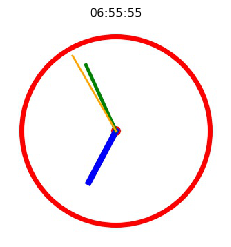

In [3]:
all_files = os.listdir(BASE_PATH)
file_name = all_files[ np.random.randint(len(all_files)) ]
image_file = os.path.join( BASE_PATH, file_name)
img = Image.open(image_file)
plt.axis('off')

time = [ int(x) for x in  file_name[6:-4].split('_') ]
plt.title( '%02d:%02d:%02d' % (time[0], time[1], time[2]) )
_ = plt.imshow( img )

In [4]:
print(img.size)

(316, 316)


In [5]:
input_size = 100
def get_model():
    base_model = VGG16(input_tensor=keras.Input(shape=(input_size, input_size, 3)),
                         weights='imagenet',include_top=False)
    base_model.trainable = False
    
    for base_layer in base_model.layers:
        base_layer.trainable = False
    layer_1 = Flatten()
    dense_1 = Dense(256, activation='relu')
    dropout_1 = Dropout(0.5)
    dense_2 = Dense(32, activation='relu')
    dense_3 = Dense(3, activation='relu')
    model = Sequential(
            [base_model, layer_1,
            dense_1, dropout_1, dense_2, dense_3]) 
    model.compile(loss='mse',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['mae'])
    return model

In [6]:
model = get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 3, 3, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1179904   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 15,902,915
Trainable params: 1,188,227
Non-trainable params: 14,714,688
__________________________________

In [7]:
def get_output_from_name( name ):
    time = name[len('clock_'):-4]
    time = [ int(x) for x in time.split('_') ]
    angles = get_angle_from_time(time[0], time[1], time[2])
    return angles

def get_angle_from_time( hour, minute, second ):
    second_angle = 6*second
    hour_angle = 30*( hour + minute/60 + second/3600) 
    minute_angle = 6*( minute + second/60)
    return [hour_angle, minute_angle, second_angle]
    
def get_all_data():
    all_files = os.listdir(BASE_PATH)
    X = np.ones((len(all_files),input_size,input_size,3))
    Y = np.ones((len(all_files),3))
    index = 0
    for file in all_files:
        file_name = os.path.join( BASE_PATH, file )
        angles = get_output_from_name( file )
        
        img = image_processor.load_img( file_name, target_size=(input_size, input_size))
        img = image_processor.img_to_array(img)
        X[index,:,:,:] = img
        Y[index,:] = angles
        index = index + 1
    return( X, Y )

In [8]:
X, Y = get_all_data()
total_examples = X.shape[0]

In [9]:
print(X.shape)
print(Y.shape)

(43200, 100, 100, 3)
(43200, 3)


In [10]:
data_indices = np.random.permutation(total_examples)
training_data_indices = data_indices[:int(0.7*total_examples)]
validation_data_indices = data_indices[int(0.7*total_examples):int(0.8*total_examples)]
testing_data_indices = data_indices[int(0.8*total_examples):]

In [11]:
train_X,train_Y = X[training_data_indices,:,:,:], Y[training_data_indices,:]
val_X,val_Y = X[validation_data_indices,:,:,:], Y[validation_data_indices,:]
test_X,test_Y = X[testing_data_indices,:,:,:], Y[testing_data_indices,:]

In [12]:
print('Total training examples:', train_X.shape[0])
print('Total validation examples:', val_X.shape[0])
print('Total testing examples:', test_X.shape[0])

Total training examples: 30239
Total validation examples: 4321
Total testing examples: 8640


In [13]:
history = model.fit(train_X, train_Y, epochs=5, validation_data=(val_X, val_Y))

Train on 30239 samples, validate on 4321 samples
Epoch 1/5
30239/30239 [==============================] - 748s 25ms/step - loss: 4270.7346 - mae: 48.5171 - val_loss: 1641.8518 - val_mae: 29.4106
Epoch 2/5
30239/30239 [==============================] - 759s 25ms/step - loss: 2428.8864 - mae: 36.3370 - val_loss: 1089.7331 - val_mae: 22.7218
Epoch 3/5
30239/30239 [==============================] - 740s 24ms/step - loss: 2019.3359 - mae: 33.0665 - val_loss: 816.9021 - val_mae: 19.0960
Epoch 4/5
30239/30239 [==============================] - 740s 24ms/step - loss: 1764.5700 - mae: 30.8897 - val_loss: 865.7644 - val_mae: 21.6885
Epoch 5/5
30239/30239 [==============================] - 745s 25ms/step - loss: 1576.7388 - mae: 28.9719 - val_loss: 1116.5660 - val_mae: 26.4837


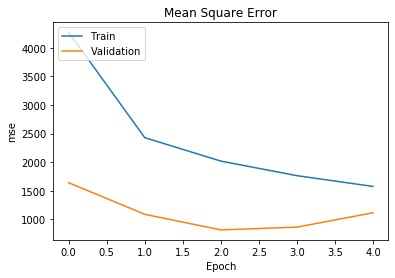

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Mean Square Error')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

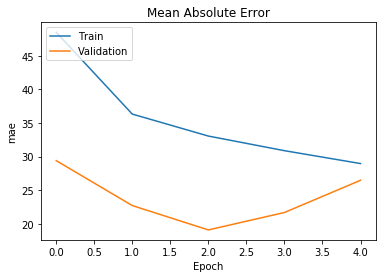

In [15]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
output = model.predict(test_X)

In [17]:
print(output.shape)

(8640, 3)


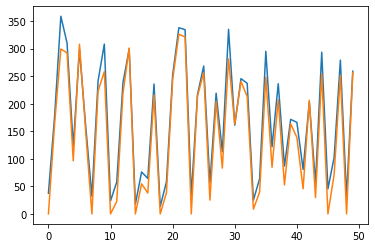

In [18]:
plt.plot(range(50), test_Y[0:50,0], label='actual'    )
plt.plot(range(50), output[0:50,0], label='predicted' )
plt.show()

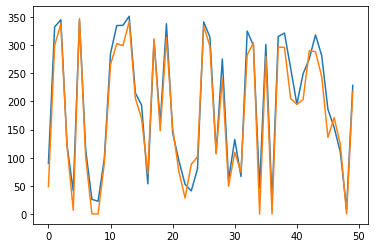

In [19]:
plt.plot(range(50), test_Y[0:50,1], label='actual'    )
plt.plot(range(50), output[0:50,1], label='predicted' )
plt.show()

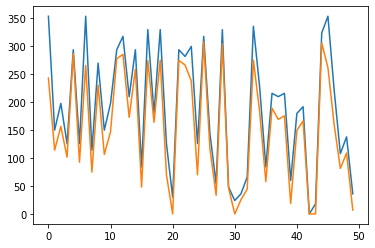

In [20]:
plt.plot(range(50), test_Y[0:50,2], label='actual'    )
plt.plot(range(50), output[0:50,2], label='predicted' )
plt.show()

In [21]:
evaluation = model.evaluate(test_X, test_Y)

8640/8640 [==============================] - 175s 20ms/step


In [22]:
evaluation

[1165.407175925926, 26.744844436645508]

In [23]:
def get_model_features():
    model = Sequential()
    model.add( Dense(32, activation='relu') )
    model.add( Dense(32, activation='relu') )
    model.add( Dense(3, activation='relu') )
    model.compile(loss='mse',
              optimizer=keras.optimizers.Adadelta(),
              metrics=['mae'])
    return model

model_features = get_model_features()

In [24]:
def get_output_from_name( name ):
    time = name[len('clock_'):-4]
    time = [ int(x) for x in time.split('_') ]
    angles = get_angle_from_time(time[0], time[1], time[2])
    return time, angles

def get_angle_from_time( hour, minute, second ):
    second_angle = 6*second
    hour_angle = 30*( hour + minute/60 + second/3600) 
    minute_angle = 6*( minute + second/60)
    return [hour_angle, minute_angle, second_angle]
    
def get_all_data():
    all_files = os.listdir(BASE_PATH)
    X = np.ones((len(all_files),3))
    Y = np.ones((len(all_files),3))
    index = 0
    for file in all_files:
        hours, angles = get_output_from_name( file )
        X[index,:] = hours
        Y[index,:] = angles
        index = index + 1
    return( X, Y )

In [25]:
X_features,Y_features = get_all_data()

In [26]:
train_X_f,train_Y_f = X_features[training_data_indices,:], Y_features[training_data_indices,:]
val_X_f,val_Y_f = X_features[validation_data_indices,:], Y_features[validation_data_indices,:]
test_X_f,test_Y_f = X_features[testing_data_indices,:], Y_features[testing_data_indices,:]

In [27]:
history_f = model_features.fit(train_X_f, train_Y_f, 
                    epochs=10, validation_data=(val_X_f, val_Y_f))

Train on 30239 samples, validate on 4321 samples
Epoch 1/10
30239/30239 [==============================] - 1s 27us/step - loss: 1800.2519 - mae: 15.5104 - val_loss: 20.2413 - val_mae: 3.7763
Epoch 2/10
30239/30239 [==============================] - 1s 22us/step - loss: 14.5411 - mae: 2.9744 - val_loss: 9.7018 - val_mae: 2.5253
Epoch 3/10
30239/30239 [==============================] - 1s 22us/step - loss: 12.1361 - mae: 2.6973 - val_loss: 22.8623 - val_mae: 4.4437
Epoch 4/10
30239/30239 [==============================] - 1s 22us/step - loss: 9.9642 - mae: 2.4228 - val_loss: 6.5051 - val_mae: 2.1260
Epoch 5/10
30239/30239 [==============================] - 1s 22us/step - loss: 9.8695 - mae: 2.3892 - val_loss: 1.7268 - val_mae: 1.1472
Epoch 6/10
30239/30239 [==============================] - 1s 25us/step - loss: 9.0666 - mae: 2.2607 - val_loss: 23.1302 - val_mae: 3.7561
Epoch 7/10
30239/30239 [==============================] - 1s 25us/step - loss: 7.9871 - mae: 2.1718 - val_loss: 8.3467 -

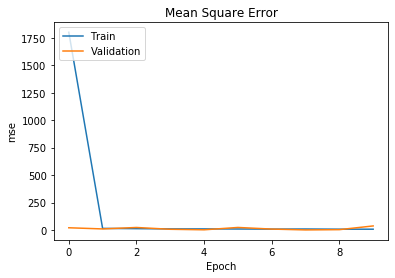

In [28]:
plt.plot(history_f.history['loss'])
plt.plot(history_f.history['val_loss'])
plt.title('Mean Square Error')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

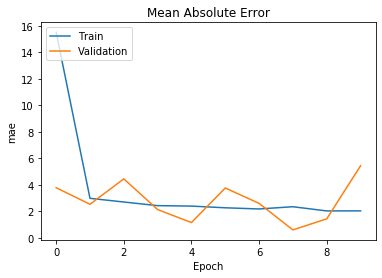

In [29]:
plt.plot(history_f.history['mae'])
plt.plot(history_f.history['val_mae'])
plt.title('Mean Absolute Error')
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [30]:
output_f = model_features.predict(test_X_f)

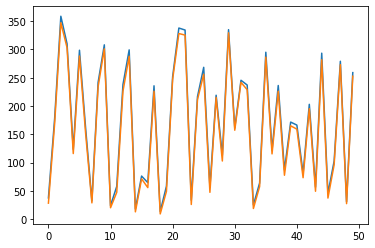

In [31]:
plt.plot(range(50), test_Y_f[0:50,0], label='actual'    )
plt.plot(range(50), output_f[0:50,0], label='predicted' )
plt.show()

In [32]:
evaluation_f = model_features.evaluate(test_X_f, test_Y_f)

8640/8640 [==============================] - 0s 11us/step


In [33]:
evaluation_f

[36.669342514320654, 5.400886535644531]

### What do we observe? Feature engineering makes it super easy and fast to train neural networks. With right features, we can incentivize models to look in that space, rather than trying to figure out patterns on its own!